# Instruction to lab work # 2: Dive deeper into principles of classification methods

> Student name    - Volodymyr

> Student surname - Donets

> Group           - KU-31


# Task description

## Part 1 (playing with generated data)

1. Set your `STUDENT_ID`, which is used as random seed, and makes your data looks a bit different.
2. Looks through `1.3. Example of using tool & experiments`, use all provided data in your experiments. But you can generate your own (more interesting & complex artificial data from your perspective)
3. In the `1.4. Task & your experiments` part do your experiments, as described select all (or a few) datasets and conduct experiments with each of the proposed methods. The idea here is to understand how various configurations of hyperparameters influence on space separations. Consider using provided hints.
4. Don't forget to write your conclusions & observations.

## Part 2 (working on the real classification problem)

1. Select 1-3 the most fascinating classification method depending on your taste.
2. Select 1 of the provided (look at the section bellow) real data for experiment.
3. Conduct experiments as shown in the example on [GitHub Repo](https://github.com/VolDonets/ML_basics_course/tree/master/lab_works/lab_3)
4. But consider tuning hyperparameters of your selected models as it was in this work and observe performance.
5. **BONUS** (+2 points): take modify function `def plot_classifier_boundary_by_dots(X, y, model=None, title=None, n_background_points=10_000): ...` to visualize decision boundaries on your real data from experiments. Hint: Here you need fit `PCA(n_components=2)` on the `X` data and used it on `X` and on `X_background` before visualizing. Also, consider that `X` and `X_background` should have the same dimension. Be aware that such visualizing might looks weird cause PCA might weirdly transform evenly distributed data in `X_background`, and it's OK.

## Proposition of the real data for experiments (for the part 2)

1. [Liver Cirrhosis Stage Classification](https://www.kaggle.com/datasets/aadarshvelu/liver-cirrhosis-stage-classification)
2. [Star Dataset for Stellar Classification](https://www.kaggle.com/datasets/vinesmsuic/star-categorization-giants-and-dwarfs)
3. [Fitness Classification Dataset](https://www.kaggle.com/datasets/muhammedderric/fitness-classification-dataset-synthetic)
4. [ECG Arrhythmia Classification Dataset](https://www.kaggle.com/datasets/sadmansakib7/ecg-arrhythmia-classification-dataset)
5. [Mushroom Classification Enhanced](https://www.kaggle.com/datasets/sakurapuare/mushroom-classification-enhanced)
6. [Dry Bean Dataset Classification](https://www.kaggle.com/datasets/nimapourmoradi/dry-bean-dataset-classification)
7. [Swarm Behaviour Classification](https://www.kaggle.com/datasets/deepcontractor/swarm-behaviour-classification) -- challenging one 270 Mb dataset
8. [Anemia Types Classification](https://www.kaggle.com/datasets/ehababoelnaga/anemia-types-classification)
9. [NASA: Asteroids Classification](https://www.kaggle.com/datasets/shrutimehta/nasa-asteroids-classification)


# Part 1: experiments with artificial data

In [1]:
STUDENT_ID = 23

## 1.1. Import dependencies

In [45]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

## 1.2. Tool functions

### 1.2.1. Kernel function for data generation

In [3]:
def gaussian_kernel(center):
    """Factory for a kernel that generates a blob of points."""

    # The returned function takes n_points and generates them around the specified center.
    return lambda n: np.repeat(np.array([center]), n, axis=0)


def circle_kernel(radius, start_angle=0, end_angle=2 * np.pi):
    """Factory for a kernel that generates points on a circle or arc."""

    def _kernel(n):
        theta = np.linspace(start_angle, end_angle, n)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return np.vstack([x, y]).T

    return _kernel


def spiral_kernel(rotations=1.5, start_radius=1.0):
    """Factory for a kernel that generates points in a spiral."""

    def _kernel(n):
        theta = np.linspace(0, rotations * 2 * np.pi, n)
        radius = np.linspace(start_radius, start_radius + (rotations * 2), n)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return np.vstack([x, y]).T

    return _kernel


def sine_wave_kernel(amplitude=1, frequency=1, x_range=(-5, 5)):
    """Factory for a kernel that generates points along a sine wave."""

    def _kernel(n):
        x = np.linspace(x_range[0], x_range[1], n)
        y = amplitude * np.sin(frequency * x)
        return np.vstack([x, y]).T

    return _kernel


def exponential_kernel(amplitude=1, base=np.e, x_range=(-2, 2)):
    """Factory for a kernel that generates points along an exponential curve."""

    def _kernel(n):
        x = np.linspace(x_range[0], x_range[1], n)
        y = amplitude * (base ** x)
        return np.vstack([x, y]).T

    return _kernel

### 1.2.2. Data generation function

In [4]:
def generate_classification_data(n_samples=200, kernels=None, kernel_classes=None,
                                 dispersion=0.2, n_outliers=10, random_seed=42):
    """
    Generates 2D, multi-class data using a flexible kernel-based approach.

    :param n_samples: The total number of data points to generate.
    :param kernels: A list of kernel functions. Each function defines a class and should
                    accept 'n' (number of points) and return an array of shape [n, 2].
    :param kernel_classes: A list of integers mapping each kernel to a class label.
                           Its length must match the length of `kernels`. If None, each kernel
                           is assigned a unique class (e.g., [0, 1, 2, ...]).
    :param dispersion: The standard deviation of Gaussian noise added to each point.
    :param n_outliers: The number of completely random points (noise) to add.
    :param random_seed: A seed for the random number generator for reproducibility.
    :returns: A tuple (X, y) where X is the feature matrix [n_samples, 2]
              and y is the label vector [n_samples,].
    """
    np.random.seed(random_seed)

    if kernels is None:
        kernels = [gaussian_kernel(center=[2, 2]),
                   gaussian_kernel(center=[-2, -2])]

    if kernel_classes is None:
        kernel_classes = list(range(len(kernels)))

    if len(kernels) != len(kernel_classes):
        raise ValueError("The length of 'kernels' and 'kernel_classes' must be the same.")

    n_classes = len(np.unique(kernel_classes))
    n_inliers = n_samples - n_outliers
    if n_inliers <= 0:
        raise ValueError("n_samples must be greater than n_outliers.")

    points_per_kernel = n_inliers // len(kernels)

    X_parts, y_parts = [], []
    for i, kernel in enumerate(kernels):
        class_label = kernel_classes[i]

        # --- THE FIX IS ON THIS LINE ---
        # Ensure the kernel output is float before adding float-based dispersion
        X_class = kernel(points_per_kernel).astype(float)

        X_class += np.random.randn(points_per_kernel, 2) * dispersion
        y_class = np.full(points_per_kernel, class_label)

        X_parts.append(X_class)
        y_parts.append(y_class)

    X_inliers = np.vstack(X_parts)
    y_inliers = np.hstack(y_parts)

    if n_outliers > 0:
        x_min, x_max = X_inliers[:, 0].min(), X_inliers[:, 0].max()
        y_min, y_max = X_inliers[:, 1].min(), X_inliers[:, 1].max()
        padding = (max(x_max - x_min, y_max - y_min)) * 0.1

        X_outliers = np.random.uniform(min(x_min, y_min) - padding,
                                       max(x_max, y_max) + padding,
                                       size=(n_outliers, 2))
        y_outliers = np.random.randint(0, n_classes, size=n_outliers)

        X = np.vstack([X_inliers, X_outliers])
        y = np.hstack([y_inliers, y_outliers])
    else:
        X, y = X_inliers, y_inliers

    permutation = np.random.permutation(X.shape[0])
    X, y = X[permutation], y[permutation]

    return X, y

### 1.2.3. Classification visualization function

In [59]:
# This function uses dots to visualize data
# You can use it if you wish (it looks like experiments in physics with electrons).

def plot_classifier_boundary_by_dots(X, y, model=None, title=None, n_background_points=10_000):
    """
    Visualizes classifier decision boundaries or acts as a simple data scatter plot.

    If a model is provided, it plots the decision regions.
    If model is None, it only plots the data points.

    :param X: The feature matrix, shape (n_samples, 2).
    :param y: The true label vector, shape (n_samples,).
    :param model: A trained scikit-learn classifier object. Optional.
    :param title: The title for the plot. A default is used if None.
    :param n_background_points: The number of random points for visualizing the background.
    """
    plt.style.use('seaborn-v0_8-pastel')
    fig, ax = plt.subplots(figsize=(8, 8))

    # 1. Plot the background decision regions only if a model is provided
    if model is not None:
        x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
        x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
        x1_pad = (x1_max - x1_min) * 0.1
        x2_pad = (x2_max - x2_min) * 0.1
        plot_x1_min, plot_x1_max = x1_min - x1_pad, x1_max + x1_pad
        plot_x2_min, plot_x2_max = x2_min - x2_pad, x2_max + x2_pad

        X_background = np.random.uniform(
            low=[plot_x1_min, plot_x2_min],
            high=[plot_x1_max, plot_x2_max],
            size=(n_background_points, 2)
        )
        background_preds = model.predict(X_background)
        
        ax.scatter(X_background[:, 0], X_background[:, 1], c=background_preds,
                   cmap=plt.cm.coolwarm, s=10, alpha=0.2, zorder=0)

    # 2. Plot the original data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', alpha=1.0, zorder=2)

    # 3. Set a dynamic title if none is provided
    if title is None:
        title = "Classifier Decision Boundary" if model is not None else "Data Scatter Plot"
    
    ax.set_xlabel("Feature 1", fontsize=12)
    ax.set_ylabel("Feature 2", fontsize=12)
    ax.set_title(title, fontsize=14, weight='bold')

    # --- Legend Creation ---
    handles, _ = scatter.legend_elements()
    num_classes = len(np.unique(y))
    class_labels = [f'Class {i}' for i in range(num_classes)]
    ax.legend(handles=handles, labels=class_labels, loc='upper right', fontsize=11)
    
    if model is not None:
        ax.set_xlim(plot_x1_min, plot_x1_max)
        ax.set_ylim(plot_x2_min, plot_x2_max)
    
    plt.show()

In [60]:
def plot_classifier_boundary(X, y, model=None, title=None, resolution=200):
    """
    Visualizes classifier decision boundaries using a high-resolution, evenly-spaced grid.

    If a model is provided, it plots the decision regions.
    If model is None, it only plots the data points.

    :param X: The feature matrix, shape (n_samples, 2).
    :param y: The true label vector, shape (n_samples,).
    :param model: A trained scikit-learn classifier object. Optional.
    :param title: The title for the plot. A default is used if None.
    :param resolution: The number of points to use per axis for the background grid.
    """
    plt.style.use('seaborn-v0_8-pastel')
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the background decision regions only if a model is provided
    if model is not None:
        # 1. Define the plot boundaries with a 10% padding
        x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
        x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
        x1_pad = (x1_max - x1_min) * 0.2
        x2_pad = (x2_max - x2_min) * 0.2
        plot_x1_min, plot_x1_max = x1_min - x1_pad, x1_max + x1_pad
        plot_x2_min, plot_x2_max = x2_min - x2_pad, x2_max + x2_pad

        # 2. Create a high-resolution, evenly-spaced grid of points
        xx1, xx2 = np.meshgrid(
            np.linspace(plot_x1_min, plot_x1_max, resolution),
            np.linspace(plot_x2_min, plot_x2_max, resolution)
        )
        
        # 3. Get the model's prediction for every point on the grid
        # We flatten the grid to pass it to the model, then reshape the predictions back
        grid_points = np.c_[xx1.ravel(), xx2.ravel()]
        Z = model.predict(grid_points)
        Z = Z.reshape(xx1.shape)
        
        # 4. Plot the regions using filled contours
        ax.contourf(xx1, xx2, Z, cmap=plt.cm.coolwarm, alpha=0.6)

    # 5. Plot the original data points on top
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', alpha=1.0, zorder=2)

    # Set a dynamic title if none is provided
    if title is None:
        title = "Classifier Decision Boundary" if model is not None else "Data Scatter Plot"
    
    ax.set_xlabel("Feature 1", fontsize=12)
    ax.set_ylabel("Feature 2", fontsize=12)
    ax.set_title(title, fontsize=14, weight='bold')

    # --- Legend Creation ---
    handles, _ = scatter.legend_elements()
    num_classes = len(np.unique(y))
    class_labels = [f'Class {i}' for i in range(num_classes)]
    ax.legend(handles=handles, labels=class_labels, loc='upper right', fontsize=11)
    
    if model is not None:
        ax.set_xlim(plot_x1_min, plot_x1_max)
        ax.set_ylim(plot_x2_min, plot_x2_max)
    
    plt.show()

### 1.2.4. Classification score function

In [46]:
def show_classification_report(X, y_true, model, title="Classification Performance"):
    """
    Calculates and displays a report of key classification metrics.

    :param X: The feature matrix of the test data.
    :param y_true: The true labels of the test data.
    :param model: A trained scikit-learn classifier object with a .predict() method.
    :param title: The title for the report and plot.
    """
    # 1. Get the model's predictions for the test data
    y_pred = model.predict(X)
    
    # Determine if it's a binary or multi-class problem
    n_classes = len(np.unique(y_true))
    
    print(f"----- 📊 {title} -----")
    
    # 2. Calculate and print the main scores
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # For multi-class, we need to specify an averaging method for precision, recall, and F1
    if n_classes > 2:
        avg_method = 'weighted'
        print(f"(Scores below are averaged using the '{avg_method}' method for multi-class)")
    else:
        avg_method = 'binary'

    precision = precision_score(y_true, y_pred, average=avg_method)
    recall = recall_score(y_true, y_pred, average=avg_method)
    f1 = f1_score(y_true, y_pred, average=avg_method)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("-" * (len(title) + 12))
    
    # 3. Calculate and visualize the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    
    ax.set_title('Confusion Matrix', fontsize=14, weight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    
    # Set tick labels for clarity
    class_labels = [f'Class {i}' for i in range(n_classes)]
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels, rotation=0)
    
    plt.show()

## 1.3. Example of using tool & experiments

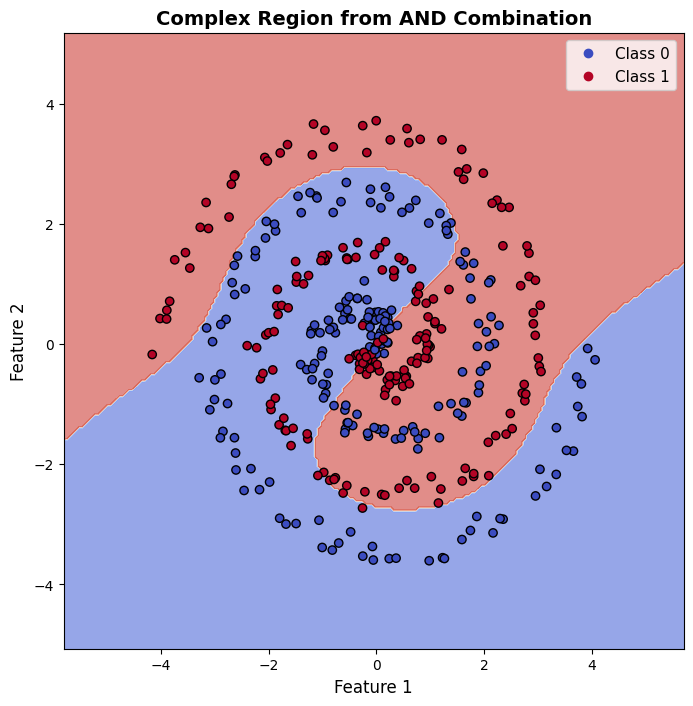

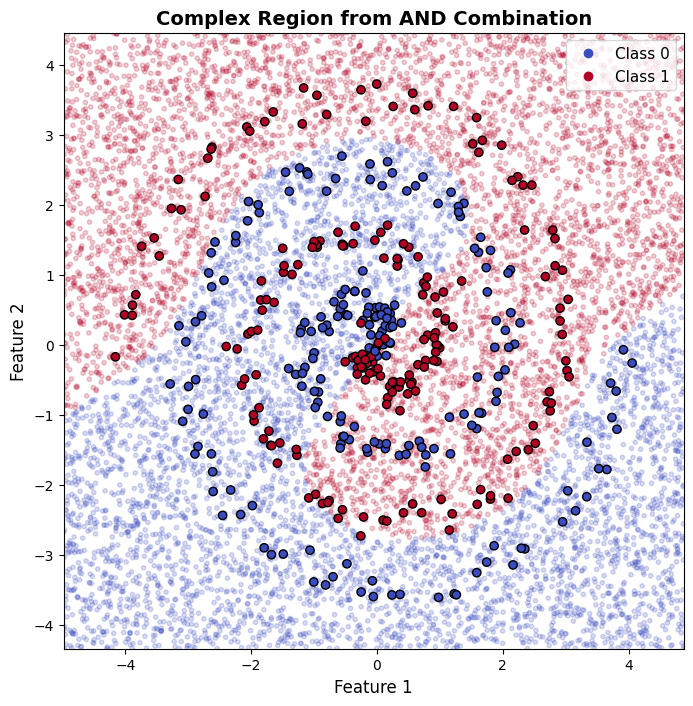

In [65]:
# Spiral data
X_data, y_data = generate_classification_data(
    n_samples=400,
    kernels=[
        spiral_kernel(rotations=2, start_radius=0),
        lambda n: -1 * spiral_kernel(rotations=2, start_radius=0)(n)  # Invert the second spiral
    ],
    kernel_classes=[0, 1],
    dispersion=0.15,
    n_outliers=0,
    random_seed=STUDENT_ID
)


# Train and test model
model = SVC(kernel="rbf")
model.fit(X_data, y_data)


# Plotting generated data
plot_classifier_boundary(X_data, y_data,
                       model=model,
                       title="Complex Region from AND Combination")

plot_classifier_boundary_by_dots(X_data, y_data,
                       model=model,
                       title="Complex Region from AND Combination")

----- 📊 Classification Performance -----
Accuracy: 0.6925
Precision: 0.6954
Recall: 0.6850
F1-Score: 0.6902
--------------------------------------


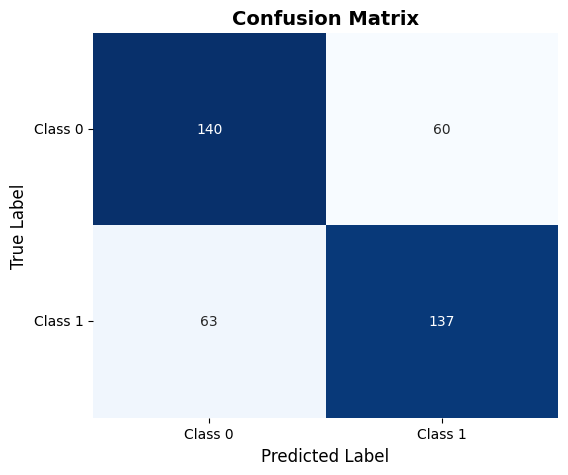

In [50]:
# Plot classification report
show_classification_report(X_data, y_data, model)

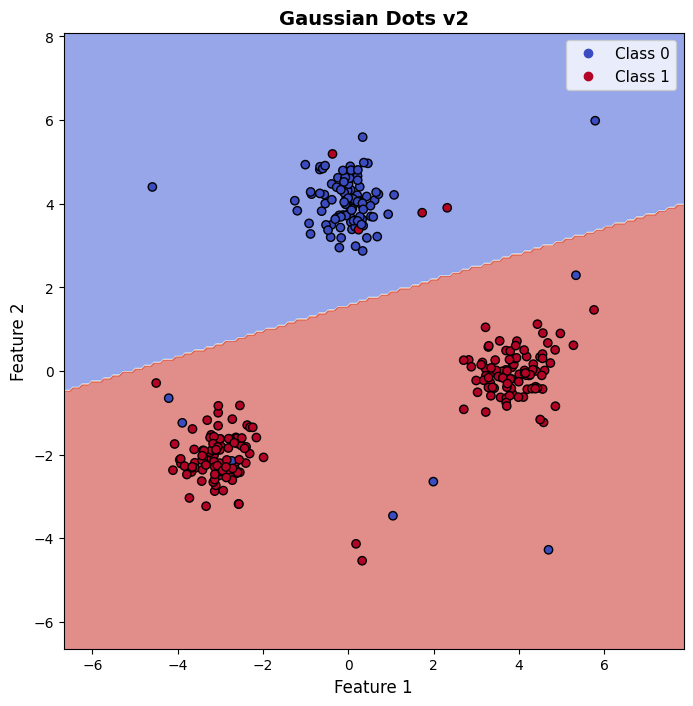

In [62]:
# Gaussian dots data v2
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[gaussian_kernel(center=[0, 4]),
             gaussian_kernel(center=[-3, -2]),
             gaussian_kernel(center=[4, 0]), ],
    kernel_classes=[0, 1, 1],
    dispersion=0.5,
    n_outliers=20,
    random_seed=STUDENT_ID,
)

# Train and test model
model = LogisticRegression()
model.fit(X_data, y_data)

# Plotting generated data
plot_classifier_boundary(X_data, y_data,
                       model=model,
                       title="Gaussian Dots v2")

----- 📊 Classification Performance -----
Accuracy: 0.9632
Precision: 0.9650
Recall: 0.9797
F1-Score: 0.9723
--------------------------------------


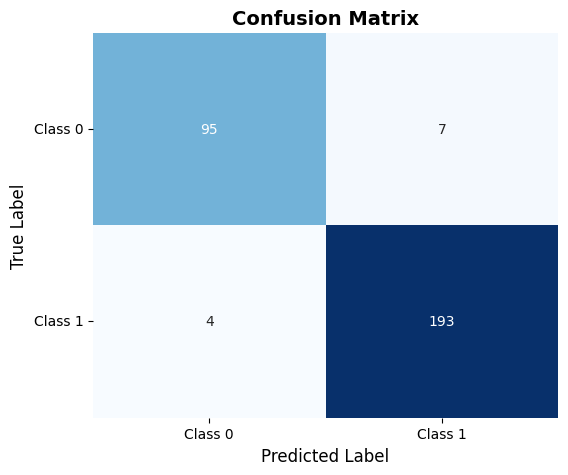

In [52]:
# Plot classification report
show_classification_report(X_data, y_data, model)

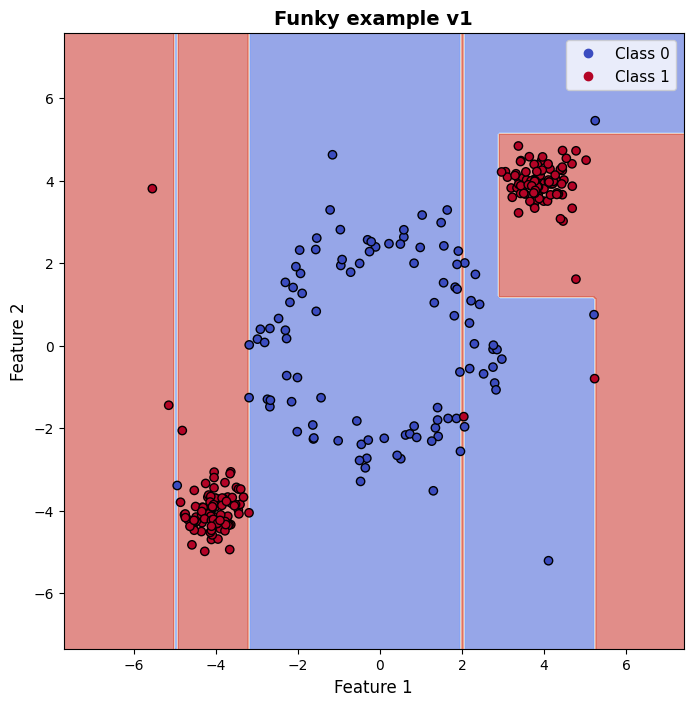

In [63]:
# Funky example v1
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[
        circle_kernel(radius=2.5),  # This will be for class 0
        gaussian_kernel(center=[-4, -4]),  # This will be part of class 1
        gaussian_kernel(center=[4, 4])  # This will also be part of class 1
    ],
    kernel_classes=[0, 1, 1],
    dispersion=0.4,
    n_outliers=15,
    random_seed=STUDENT_ID
)

# Train and test model
model = DecisionTreeClassifier()
model.fit(X_data, y_data)

# Plotting generated data
plot_classifier_boundary(X_data, y_data,
                       model=model,
                       title="Funky example v1")

----- 📊 Classification Performance -----
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
--------------------------------------


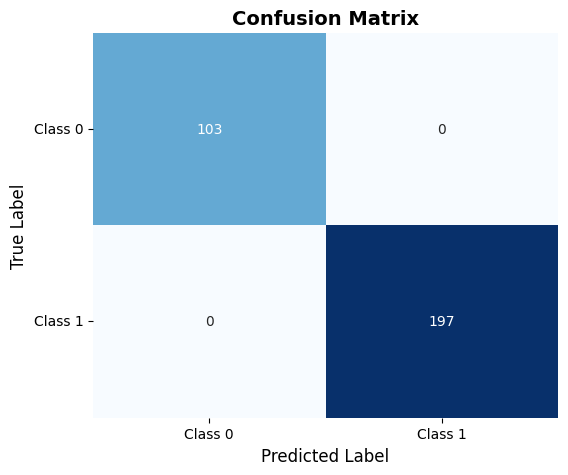

In [54]:
# Plot classification report
show_classification_report(X_data, y_data, model)

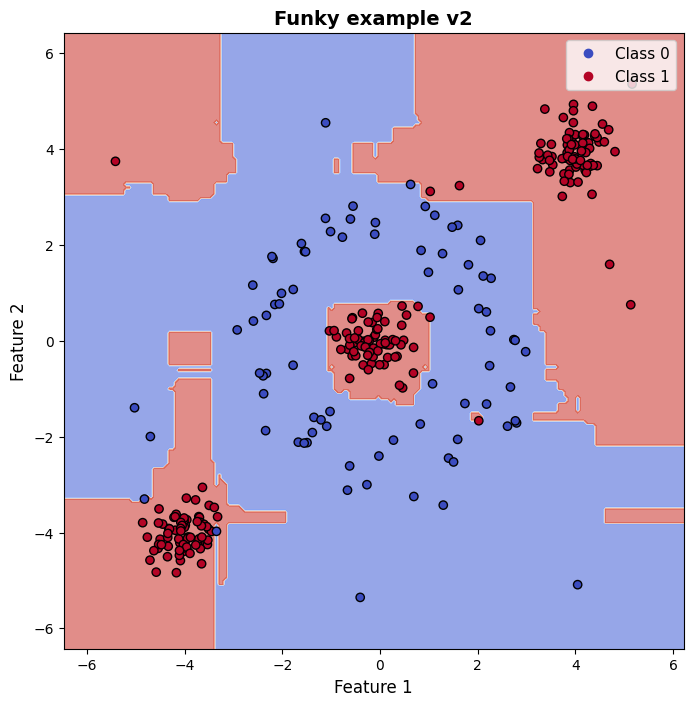

In [55]:
# Funky example v2
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[
        circle_kernel(radius=2.5),  # This will be for class 0
        gaussian_kernel(center=[-4, -4]),  # This will be part of class 1
        gaussian_kernel(center=[4, 4]),  # This will also be part of class 1
        gaussian_kernel(center=[0, 0]),  # This will also be part of class 1
    ],
    kernel_classes=[0, 1, 1, 1],
    dispersion=0.4,
    n_outliers=15,
    random_seed=STUDENT_ID
)

# Train and test model
model = RandomForestClassifier()
model.fit(X_data, y_data)

# Plotting generated data
plot_classifier_boundary(X_data, y_data,
                       model=model,
                       title="Funky example v2")

----- 📊 Classification Performance -----
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
--------------------------------------


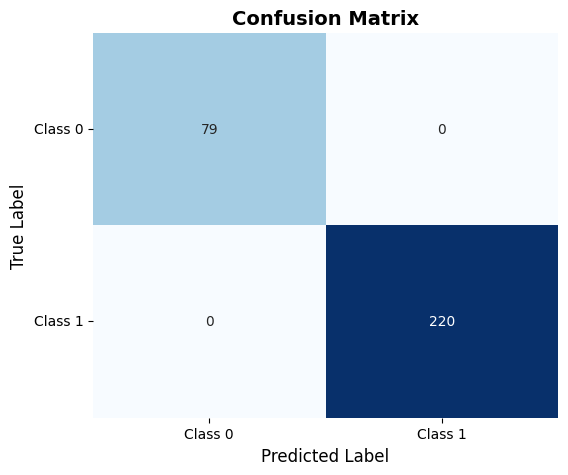

In [56]:
# Plot classification report
show_classification_report(X_data, y_data, model)

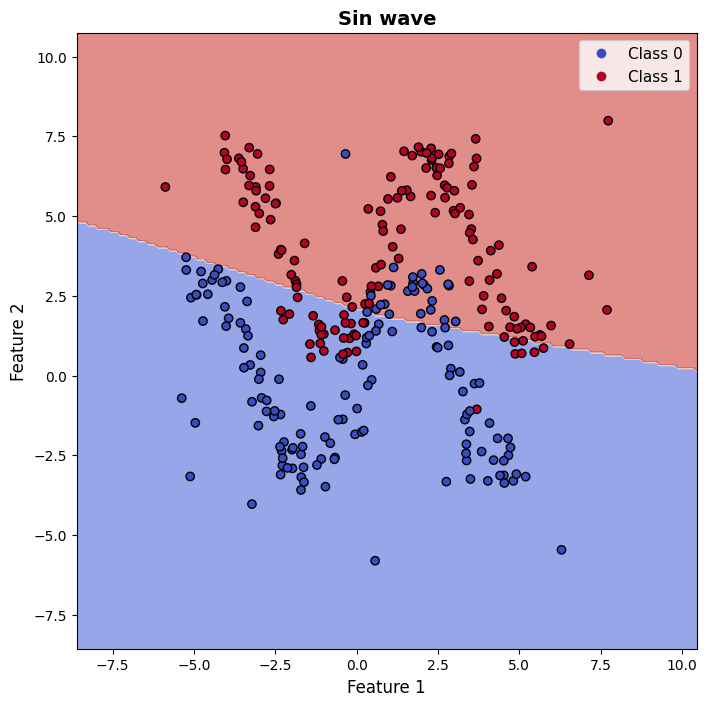

In [64]:
# Sin wave
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[
        lambda x_: sine_wave_kernel(amplitude=3, frequency=1, x_range=[-5, 5])(x_),
        lambda x_: 4 + sine_wave_kernel(amplitude=-3, frequency=1, x_range=[-8, 2])(x_),
    ],
    kernel_classes=[0, 1],
    dispersion=0.4,
    n_outliers=15,
    random_seed=STUDENT_ID
)

# Train and test model
clf1 = LogisticRegression()
clf2 = GaussianNB()
model = VotingClassifier(estimators=[
        ('lr', clf1), ('gnb', clf2)], voting='hard')
model.fit(X_data, y_data)

# Plotting generated data
plot_classifier_boundary(X_data, y_data,
                       model=model,
                       title="Sin wave")

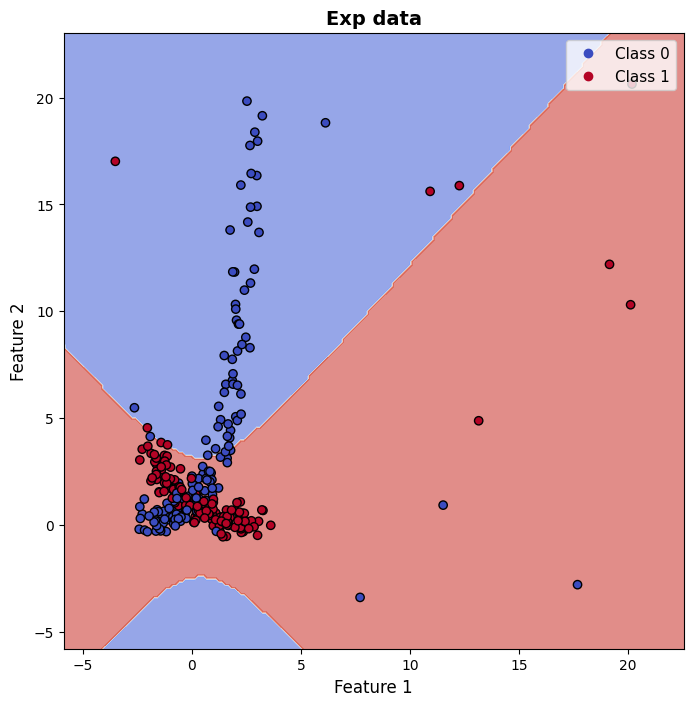

In [42]:
# Exp data
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[
        # Class 0: Exponential growth
        exponential_kernel(amplitude=1, base=np.e, x_range=(-2, 3)),
        # Class 1: Exponential decay
        exponential_kernel(amplitude=1, base=0.5, x_range=(-2, 3))
    ],
    dispersion=0.4,
    n_outliers=15,
    random_seed=STUDENT_ID
)

# Train and test model
model = GaussianNB()
model.fit(X_data, y_data)

# Plotting generated data
plot_classifier_boundary(X_data, y_data,
                       model=model,
                       title="Exp data")

----- 📊 Classification Performance -----
Accuracy: 0.7993
Precision: 0.8112
Recall: 0.7785
F1-Score: 0.7945
--------------------------------------


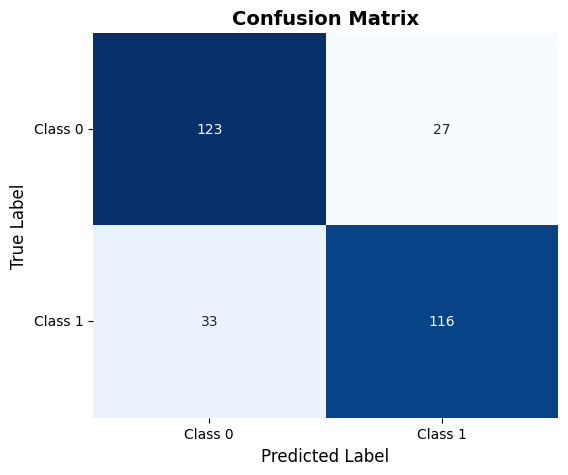

In [58]:
# Plot classification report
show_classification_report(X_data, y_data, model)

## 1.4. Task & your experiments

Using provided artificial data (or your own data, you can make, as complex as you wish) do experiments on each of the proposed model.
Make them work better and worse. Observe in changing `accuracy`, `precision`, `recall`, and `f1-score` depending on your data and models' configurations.
Make conclusions in the end: like what model is the most universal/simple/complex and why. Which model's hyperparameters has the biggest impact on the model's performance. 
Also conduct as least 3 experiment on each model. 

### 1.4.1. Experiment on `GaussianNB`

**Hint**: `var_smoothing`: This is the most important (and often only) parameter to adjust.

  * _What it does_: It's a stability parameter that adds a small value to the variance of each feature. This prevents issues if a feature has zero variance in your training data. Think of it as a safety net to prevent the model from becoming too certain based on limited data.
  * _What to try_: It's a small float. Experiment with values like `1e-10`, `1e-9` (default), `1e-7`, `1e-5`.
  * _Expected effect_: Increasing var_smoothing can make the model more robust to noisy features (reducing overfitting), but making it too large will "smooth out" the data too much, leading to underfitting.

### 1.4.2. Experiment on `LogisticRegression`

**Hint**: This is a fundamental linear model. Its complexity is controlled by regularization.

1. `C`: The inverse of regularization strength. This is the most critical hyperparameter.
    * _What it does_: It controls the penalty for model complexity. A small `C` creates a strong penalty, forcing the model to be simpler (more regularization). A large `C` creates a weak penalty, allowing the model to be more complex and fit the training data more closely.
    * _What to try_: Use a logarithmic scale, as the effect is not linear. Try values like `0.01`, `0.1`, `1`, `10`, `100`.
    * _Expected effect_: Small C values risk underfitting, while large C values risk overfitting.


2. `penalty`: The type of regularization to use.
    * _What it does_: Determines how the model's weights are penalized. `l2` (the default) is a general-purpose penalty. `l1` can force some feature weights to become exactly zero, effectively performing feature selection.
    * _What to try_: Compare `l2` with `l1`. Note: You may need to change the solver, as not all solvers support the `l1` penalty (e.g., `solver='liblinear'` or `solver='saga'` works with `l1`).

### 1.4.3. Experiment on `SVC` (considered independent experiments on each kernel)

**Hint**: SVCs are powerful and their behavior is highly dependent on these three parameters.
1. `C`: The regularization parameter.
   * _What it does_: Controls the trade-off between having a smooth, wide decision boundary (margin) and correctly classifying as many training points as possible. A small `C` allows for a wider margin and more misclassifications. A large `C` pushes for a narrower margin, trying to classify every point correctly.
   * _What to try_: A logarithmic scale: `0.1`, `1`, `10`, `100`.
2. `kernel`: The function used to transform the data.
   * _What it does_: It maps the data into a higher-dimensional space, allowing the model to find non-linear boundaries.
   * _What to try_: `linear` for a straight-line boundary, and `rbf` (Radial Basis Function) for a complex, curved boundary. The `rbf` kernel is the default and usually the most powerful.
3. `gamma`: The kernel coefficient for `rbf`.
   * _What it does_: Defines the "radius of influence" of a single training point. A small gamma means a point has a far-reaching influence, resulting in a smoother, more general boundary. A large gamma means a point has a very local influence, leading to a more complex, wiggly boundary that closely follows the data.
   * _What to try_: A logarithmic scale: `0.001`, `0.01`, `0.1`, `1`. You can also try the default `scale`.

### 1.4.4. Experiment on `DecisionTreeClassifier`

**Hint**: The key is to control the tree's growth to prevent overfitting.
1. `max_depth`: The maximum number of levels in the tree.
    * _What it does_: This is the most direct way to control model complexity. A shallow tree is simple; a deep tree is complex.
    * _What to try_: Integers like `3`, `5`, `10`, or `None` (which lets the tree grow until all leaves are pure).
    * _Expected effect_: A small max_depth will likely underfit. A very large or None max_depth will almost certainly overfit the training data.

2. `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
    * _What it does_: Prevents the tree from creating leaves for very small, specific groups of data points. Think of it as a rule saying, "don't make a final decision based on just one or two examples."
    * _What to try_: Integers like `1` (the default), `5`, `10`, `20`.
    * _Expected effect_: Increasing this value makes the model more conservative and less prone to overfitting on noise.

### 1.4.5. Experiment on `RandomForestClassifier`

**Hint**: A Random Forest is an ensemble of many Decision Trees, so you tune both the forest and the trees within it.
1. `n_estimators`: The number of trees in the forest.
    * _What it does_: Controls the size of the ensemble.
    * _What to try_: Integers like `10`, `50`, `100`, `200`.
    * _Expected effect_: More trees generally improve performance and stability, though with diminishing returns. Unlike many other parameters, a higher `n_estimators` doesn't usually cause overfitting, it just increases compute time.

2. `max_depth`: The maximum depth of each individual tree.
    * _What it does_: Controls the complexity of each tree in the forest.
    * _What to try_: `5`, `10`, `20`, or `None`.
    * _Expected effect_: Because a Random Forest averages the results of many trees, it's more robust to deep, overfit individual trees than a single `DecisionTreeClassifier`. However, limiting the depth can still be an effective way to regularize the model.

### 1.4.6. Experiment on `VotingClassifier`

**Hint**: This model combines other models, so the experiment is about the combination itself.
1. `estimators`: The list of models to combine.
    * _What it does_: This is the core configuration. You provide a list of other instantiated models. The experiment here is not just tuning their hyperparameters, but choosing which models to include.
    * _What to try: Combine diverse models_. A great experiment is to combine a linear model with a non-linear one, e.g.,` estimators=[('lr', LogisticRegression(C=10)), ('rf', RandomForestClassifier(n_estimators=50))]`.

2. `voting`: The strategy for combining predictions.
    * _What it does_: `hard` voting uses the majority vote from the classifiers. `soft` voting averages the predicted probabilities from each model and picks the class with the highest average probability.
    * _What to try_: Compare `hard` vs. `soft`.
    * _Expected effect_: `soft` voting often performs better because it considers the confidence of each model's prediction. Note: For `soft` voting, all included models must have a `.predict_proba()` method (e.g., for SVC you must set `probability=True`).

## 1.5. Conclusions

# Part 2

Go to the 2nd notebook and play with real data.
Example with code on [GitHub Repo](https://github.com/VolDonets/ML_basics_course/tree/master/lab_works/lab_3)